# CSCI-S89 Harvard Introduction to Deep Learning Project

## Emotion Detection From Live Images

### Preprocessing the data

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from tqdm import tqdm
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

#### Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip '/content/drive/My Drive/fer2013.zip'

Archive:  /content/drive/My Drive/fer2013.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.csv             


#### Reading Dataset.
A full comprehensible emotion dataset can be found [here](https://www.kaggle.com/deadskull7/fer2013)

Once you download the dataset, please put it in a zip folder inside your google-drive.

Using the above command, you can unzip the file and store it in colab memory.

In [4]:
df = pd.read_csv('fer2013.csv')

##### About the Dataset

The dataset has 3 columns, emotion ID, pixels of the image and usage of each image (Train or test)

Emotion ID

1: Angry

2: Disgusted

3: Fearful

4: Happy

5: Sad

6: Surprised

7: Neutral

In [5]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


#### Folder Structure
Separating each image to its respective folders

In [6]:
# convert string to integer
def atoi(s):
    n = 0
    for i in s:
        n = n*10 + ord(i) - ord("0")
    return n

In [7]:
outer_names = ['test','train']
inner_names = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
os.makedirs('data', exist_ok=True)
for outer_name in outer_names:
    os.makedirs(os.path.join('data',outer_name), exist_ok=True)
    for inner_name in inner_names:
        os.makedirs(os.path.join('data',outer_name,inner_name), exist_ok=True)

In [8]:
# to keep count of each category
angry = 0
disgusted = 0
fearful = 0
happy = 0
sad = 0
surprised = 0
neutral = 0
angry_test = 0
disgusted_test = 0
fearful_test = 0
happy_test = 0
sad_test = 0
surprised_test = 0
neutral_test = 0

In [9]:
mat = np.zeros((48,48),dtype=np.uint8)
print("Saving images...")

Saving images...


In [10]:
os.chdir("data")

In [11]:
# read the csv file line by line
for i in tqdm(range(len(df))):
    txt = df['pixels'][i]
    words = txt.split()
    
    # the image size is 48x48
    for j in range(2304):
        xind = j // 48
        yind = j % 48
        mat[xind][yind] = atoi(words[j])

    img = Image.fromarray(mat)

    # train
    if i < 28709:
        if df['emotion'][i] == 0:
            img.save('train/angry/im'+str(angry)+'.png')
            angry += 1
        elif df['emotion'][i] == 1:
            img.save('train/disgusted/im'+str(disgusted)+'.png')
            disgusted += 1
        elif df['emotion'][i] == 2:
            img.save('train/fearful/im'+str(fearful)+'.png')
            fearful += 1
        elif df['emotion'][i] == 3:
            img.save('train/happy/im'+str(happy)+'.png')
            happy += 1
        elif df['emotion'][i] == 4:
            img.save('train/sad/im'+str(sad)+'.png')
            sad += 1
        elif df['emotion'][i] == 5:
            img.save('train/surprised/im'+str(surprised)+'.png')
            surprised += 1
        elif df['emotion'][i] == 6:
            img.save('train/neutral/im'+str(neutral)+'.png')
            neutral += 1

    # test
    else:
        if df['emotion'][i] == 0:
            img.save('test/angry/im'+str(angry_test)+'.png')
            angry_test += 1
        elif df['emotion'][i] == 1:
            img.save('test/disgusted/im'+str(disgusted_test)+'.png')
            disgusted_test += 1
        elif df['emotion'][i] == 2:
            img.save('test/fearful/im'+str(fearful_test)+'.png')
            fearful_test += 1
        elif df['emotion'][i] == 3:
            img.save('test/happy/im'+str(happy_test)+'.png')
            happy_test += 1
        elif df['emotion'][i] == 4:
            img.save('test/sad/im'+str(sad_test)+'.png')
            sad_test += 1
        elif df['emotion'][i] == 5:
            img.save('test/surprised/im'+str(surprised_test)+'.png')
            surprised_test += 1
        elif df['emotion'][i] == 6:
            img.save('test/neutral/im'+str(neutral_test)+'.png')
            neutral_test += 1

print("Done!")

100%|██████████| 35887/35887 [01:57<00:00, 304.31it/s]

Done!


#### Plot Function

In [12]:
# Filtering out any errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [13]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

In [14]:
train_dir = 'train'
val_dir = 'test'

In [15]:
num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

#### Image Generator

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

##### GrayScale

In [17]:
train_generator_gray = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator_gray = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##### Color Scale

In [18]:
train_generator_color = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_color = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Model Creation

#### Mobile Net V2

Usig Mobile Net V2 Pretrained Model

A family of general purpose computer vision neural networks designed with mobile devices in mind to support classification, detection and more.

Architecture:

In [19]:
mv2_base_2 = MobileNetV2 (
   input_shape = (48, 48, 3), 
   alpha = 1.0, 
   include_top = False, 
   weights = 'imagenet', 
   input_tensor = None, 
   pooling = None, 
   classes = 1000,
)

In [ ]:
model = Sequential()
model.add(mv2_base_2)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit_generator(
        train_generator_color,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator_color,
        validation_steps=num_val // batch_size)

##### Test vs Validation accuracy and loss; Confusion Matrix

###### Graphs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


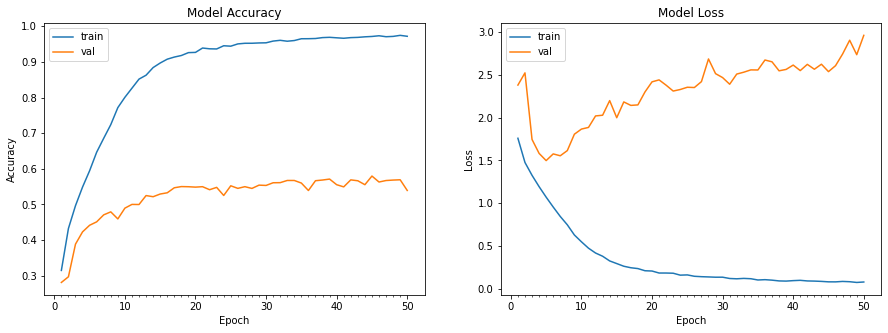

In [22]:
plot_model_history(model_info)

###### Confusion Matrix

In [24]:
from tensorflow.math import confusion_matrix
emoji_pred = model.predict_generator(validation_generator_color, num_val // batch_size+1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [28]:
con_mat = confusion_matrix(validation_generator_color.classes, np.argmax(emoji_pred, axis=1)).numpy()

In [30]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = inner_names, 
                     columns = inner_names)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


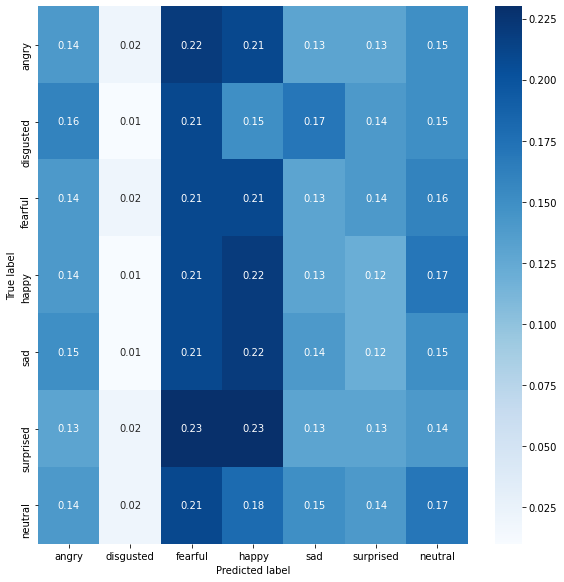

In [31]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Saving Model

In [32]:
model.save_weights('/content/drive/My Drive/data/mobilenet_model.h5')

In [33]:
model_json = model.to_json()
with open("/content/drive/My Drive/data/mobilenet_model.json", "w") as json_file:
    json_file.write(model_json)

#### VGG16

In [34]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(48, 48, 3))

In [ ]:
conv_base.summary()

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit_generator(
        train_generator_color,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator_color,
        validation_steps=num_val // batch_size)

##### Test vs Validation Accuracy adn Loss; Confusion Matrix

###### Graphs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


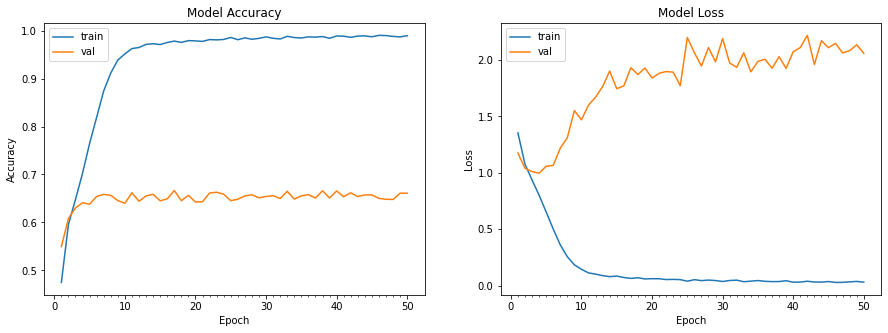

In [38]:
plot_model_history(model_info)

###### Confusion Matrix

In [39]:
emoji_pred = model.predict_generator(validation_generator_color, num_val // batch_size+1)
con_mat = confusion_matrix(validation_generator_color.classes, np.argmax(emoji_pred, axis=1)).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = inner_names, 
                     columns = inner_names)

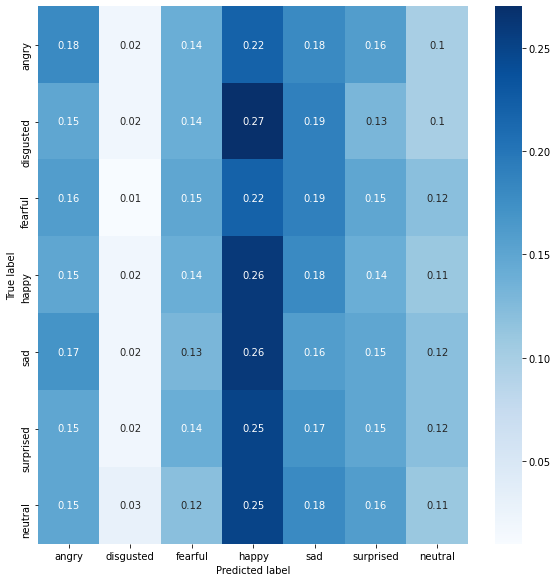

In [40]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Saving the Model

In [41]:
model.save_weights('/content/drive/My Drive/data/vgg_model.h5')

In [42]:
model_json = model.to_json()
with open("/content/drive/My Drive/data/vgg_model.json", "w") as json_file:
    json_file.write(model_json)

#### Normal CNN

In [43]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit_generator(
        train_generator_gray,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator_gray,
        validation_steps=num_val // batch_size)

##### Test vs Validation Accuracy and Loss; Confusion Matrix

###### Graphs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


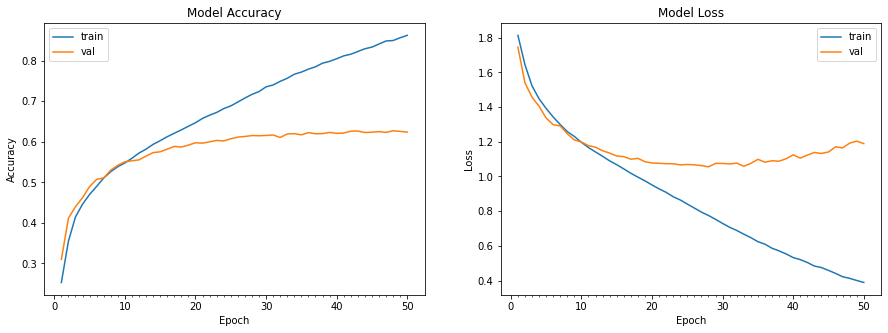

In [45]:
plot_model_history(model_info)

###### Confusion Matrix

In [49]:
emoji_pred = model.predict_generator(validation_generator_gray, num_val // batch_size+1)
con_mat = confusion_matrix(validation_generator_gray.classes, np.argmax(emoji_pred, axis=1)).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = inner_names, 
                     columns = inner_names)

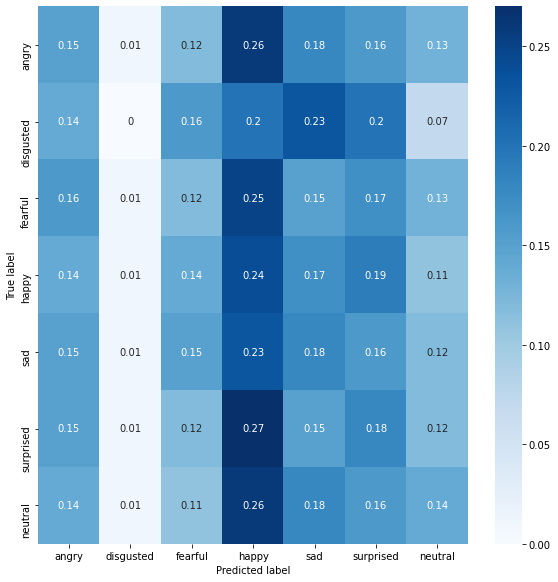

In [50]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Saving Models 

In [52]:
model.save_weights('/content/drive/My Drive/data/model.h5')

In [53]:
model.save('/content/drive/My Drive/data/loaded_model.h5')

In [54]:
model_json = model.to_json()
with open("/content/drive/My Drive/data/model.json", "w") as json_file:
    json_file.write(model_json)